All right reserved by #https://github.com/apache/incubator-mxnet/blob/master/docs/tutorials/onnx/fine_tuning_gluon.md

In [1]:
import json
import logging
import multiprocessing
import os
import tarfile

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import mxnet.contrib.onnx as onnx_mxnet
import numpy as np

%matplotlib inline

In [2]:
image_folder = "images"
utils_file = "utils.py" # contain utils function to plot nice visualization
images = ['wrench.jpg', 'dolphin.jpg', 'lotus.jpg']
base_url = "https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/onnx/{}?raw=true"


# for image in images:
#     mx.test_utils.download(base_url.format("{}/{}".format(image_folder, image)), fname=image,dirname=image_folder)
# mx.test_utils.download(base_url.format(utils_file), fname=utils_file)

from utils import *

A pretrained GoogleNet model is used in this experiment.
This model is trained on ImageNet from the ONNX model zoo. 
The model comes packaged in an archive tar.gz file containing an model.onnx model file.

In [3]:
base_url = "https://s3.amazonaws.com/download.onnx/models/opset_3/"
current_model = "mobilenetv2-1.0"
model_folder = "model"
archive_file = "{}.tar.gz".format(current_model)
archive_path = os.path.join(model_folder, archive_file)
url = "{}{}".format(base_url, archive_file)
#onnx_path = os.path.join(model_folder, current_model, 'model.onnx')
onnx_path = os.path.join(model_folder, current_model, 'model.onnx')

# # Download the zipped model
# mx.test_utils.download(url, dirname = model_folder)

# # Extract the model
# if not os.path.isdir(os.path.join(model_folder, current_model)):
#     print('Extracting {} in {}...'.format(archive_path, model_folder))
#     tar = tarfile.open(archive_path, "r:gz")
#     tar.extractall(model_folder)
#     tar.close()
#     print('Model extracted.')


In [4]:
data_folder = "data"
dataset_name = "101_ObjectCategories"
archive_file = "{}.tar.gz".format(dataset_name)
archive_path = os.path.join(data_folder, archive_file)
data_url = "https://s3.us-east-2.amazonaws.com/mxnet-public/"

# if not os.path.isfile(archive_path):
#     mx.test_utils.download("{}{}".format(data_url, archive_file), dirname = data_folder)
#     print('Extracting {} in {}...'.format(archive_file, data_folder))
#     tar = tarfile.open(archive_path, "r:gz")
#     tar.extractall(data_folder)
#     tar.close()
#     print('Data extracted.')

In [5]:
training_path = "/home/murshed/phd/git_research/mldledge/mxnet/train_model_with_own_dataset_inceptionnet/data/101_ObjectCategories"
testing_path = "/home/murshed/phd/git_research/mldledge/mxnet/train_model_with_own_dataset_inceptionnet/data/101_ObjectCategories_test"

In [6]:
EDGE = 224
SIZE = (EDGE, EDGE)
BATCH_SIZE = 32
NUM_WORKERS = 6

In [7]:
def transform(image, label):
    resized = mx.image.resize_short(image, EDGE)
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    transposed = nd.transpose(cropped, (2,0,1))
    return transposed, label

In [8]:
dataset_train = ImageFolderDataset(root=training_path)
dataset_test = ImageFolderDataset(root=testing_path)

In [9]:
dataloader_train = DataLoader(dataset_train.transform(transform, lazy=False), batch_size=BATCH_SIZE, last_batch='rollover',
                              shuffle=True, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test.transform(transform, lazy=False), batch_size=BATCH_SIZE, last_batch='rollover',
                             shuffle=False, num_workers=NUM_WORKERS)
print("Train dataset: {} images, Test dataset: {} images".format(len(dataset_train), len(dataset_test)))

Train dataset: 844 images, Test dataset: 200 images


In [10]:
categories = dataset_train.synsets
NUM_CLASSES = len(categories)
BATCH_SIZE = 32

clean


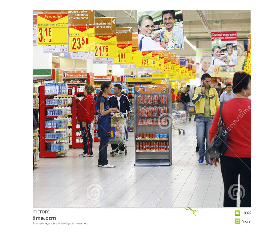

In [11]:
N = 100
plt.imshow((transform(dataset_train[N][0], 0)[0].asnumpy().transpose((1,2,0))))
plt.axis('off')
print(categories[dataset_train[N][1]])

In [12]:
sym, arg_params, aux_params = onnx_mxnet.import_model(onnx_path)
def get_layer_output(symbol, arg_params, aux_params, layer_name):
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.Flatten(data=net)
    new_args = dict({k:arg_params[k] for k in arg_params if k in net.list_arguments()})
    new_aux = dict({k:aux_params[k] for k in aux_params if k in net.list_arguments()})
    return (net, new_args, new_aux)

sym.get_internals()


<Symbol group [data, pad0, mobilenetv20_features_conv0_weight, convolution0, mobilenetv20_features_batchnorm0_gamma, mobilenetv20_features_batchnorm0_beta, mobilenetv20_features_batchnorm0_running_mean, mobilenetv20_features_batchnorm0_running_var, mobilenetv20_features_batchnorm0_fwd, mobilenetv20_features_relu0_fwd, pad1, mobilenetv20_features_linearbottleneck0_conv0_weight, convolution1, mobilenetv20_features_linearbottleneck0_batchnorm0_gamma, mobilenetv20_features_linearbottleneck0_batchnorm0_beta, mobilenetv20_features_linearbottleneck0_batchnorm0_running_mean, mobilenetv20_features_linearbottleneck0_batchnorm0_running_var, mobilenetv20_features_linearbottleneck0_batchnorm0_fwd, mobilenetv20_features_linearbottleneck0_relu0_fwd, pad2, mobilenetv20_features_linearbottleneck0_conv1_weight, convolution2, mobilenetv20_features_linearbottleneck0_batchnorm1_gamma, mobilenetv20_features_linearbottleneck0_batchnorm1_beta, mobilenetv20_features_linearbottleneck0_batchnorm1_running_mean, m

In [13]:
new_sym, new_arg_params, new_aux_params = get_layer_output(sym, arg_params, aux_params, 'mobilenetv20_output_flatten0_reshape0')

In [14]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

In [15]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pre_trained = gluon.nn.SymbolBlock(outputs=new_sym, inputs=mx.sym.var('data'))

net_params = pre_trained.collect_params()

for param in new_arg_params:
    if param in net_params:
        net_params[param]._load_init(new_arg_params[param], ctx=ctx)
for param in new_aux_params:
    if param in net_params:
        net_params[param]._load_init(new_aux_params[param], ctx=ctx)

In [16]:
print(pre_trained.collect_params())

(
  Parameter mobilenetv20_features_conv0_weight (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_batchnorm0_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_batchnorm0_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck0_conv0_weight (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck0_batchnorm0_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck0_batchnorm0_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck0_conv1_weight (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck0_batchnorm1_gamma (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck0_batchnorm1_beta (shape=None, dtype=<class 'numpy.float32'>)
  Parameter mobilenetv20_features_linearbottleneck

In [17]:
dense_layer = gluon.nn.Dense(NUM_CLASSES)
dense_layer.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [18]:
net = gluon.nn.HybridSequential()
net.hybridize()
with net.name_scope():
    net.add(pre_trained)
    net.add(dense_layer)
#print(pre_trained)

In [19]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [20]:
LEARNING_RATE = 0.001
WDECAY = 0.0005
MOMENTUM = 0.9

In [21]:
# for param in net_params:
#     print(param)


In [22]:
# old_net = net
# #print(old_net.collect_params())
# if param in old_net:
#     print("what is : ", param)

In [23]:
net.collect_params().initialize(ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE,
                         'wd':WDECAY,
                         'momentum':MOMENTUM})

/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'mobilenetv20_features_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'mobilenetv20_features_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'mobilenetv20_features_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'mobilenetv20_features_linearbottleneck0_conv0_weight' is alrea

In [24]:
def evaluate_accuracy_gluon(data_iterator, net):
    num_instance = 0
    sum_metric = nd.zeros(1,ctx=ctx, dtype=np.int32)
    for i, (data, label) in enumerate(data_iterator):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.astype(np.int32).as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1).astype(np.int32)
        num_instance += len(prediction)
        sum_metric += (prediction==label).sum()
    accuracy = (sum_metric.astype(np.float32)/num_instance)
    return accuracy.asscalar()


In [25]:
%%time
print("Untrained network Test Accuracy: {0:.4f}".format(evaluate_accuracy_gluon(dataloader_test, net)))

Untrained network Test Accuracy: 0.5208
CPU times: user 1.88 s, sys: 658 ms, total: 2.53 s
Wall time: 2.52 s


In [26]:
val_accuracy = 0
for epoch in range(10):
    for i, (data, label) in enumerate(dataloader_train):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.as_in_context(ctx)

        if i%20==0 and i >0:
            print('Batch [{0}] loss: {1:.4f}'.format(i, loss.mean().asscalar()))

        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

    nd.waitall() # wait at the end of the epoch    
    new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, net)    
    print("Epoch [{0}] Test Accuracy {1:.4f} ".format(epoch, new_val_accuracy))

    # We perform early-stopping regularization, to prevent the model from overfitting
#     if val_accuracy > new_val_accuracy:
#         print('Validation accuracy is decreasing, stopping training')
#         break
    val_accuracy = new_val_accuracy

Batch [20] loss: 1.2092
Epoch [0] Test Accuracy 0.4792 
Batch [20] loss: 0.2554
Epoch [1] Test Accuracy 0.4740 
Batch [20] loss: 0.5226
Epoch [2] Test Accuracy 0.9241 
Batch [20] loss: 0.0043
Epoch [3] Test Accuracy 0.9115 
Batch [20] loss: 0.0217
Epoch [4] Test Accuracy 0.9115 
Batch [20] loss: 0.0601
Epoch [5] Test Accuracy 0.9219 
Batch [20] loss: 0.0073
Epoch [6] Test Accuracy 0.9241 
Batch [20] loss: 0.0175
Epoch [7] Test Accuracy 0.9115 
Batch [20] loss: 0.0026
Epoch [8] Test Accuracy 0.9010 
Batch [20] loss: 0.0004
Epoch [9] Test Accuracy 0.9062 


In [27]:
#Save net parameters
net.export(current_model, 100)
saved_model = current_model + '.params'
print (saved_model)
net.save_parameters(saved_model)

mobilenetv2-1.0.params


In [28]:
def transform(img):
    return nd.array(np.expand_dims(np.transpose(img, (2,0,1)),axis=0).astype(np.float32), ctx=ctx)

In [29]:
import os
import subprocess
import time
import cv2
import psutil

#path = os.getcwd()
path = '/home/murshed/phd/git_research/mldledge/tensorflow/fine-tuneUsingtf/edgetpu/hazard_data/testdata_onCoral/sdir/'
script_path = '/usr/lib/python3/dist-packages/edgetpu/demo/'
#folders = []

files = os.listdir(path)
#print (files)

images = {}
false_assum = {}

for file in files:
   if 'hazard' in file:
      images.update({file : 'hazard'})
   elif 'clean' in file:
      images.update({file : 'clean'})

#print (images)

total_time = 0
for key in images:
   print ('\n\nImage name : ',key, 'Tag: ' , images[key], 'floor and the classification result is : ' )
   
   img = cv2.imread(path+key)
   img = cv2.resize(img,(224,224))
   #img = np.reshape(img,[1,224,224,3])
   #image = tf.cast(img, tf.float32)
   image = transform(img)
   start_time = time.time()
   classes = net(image)
   total_time = total_time + (time.time()-start_time)
   print(classes)
   pid = os.getpid()
   py = psutil.Process(pid)
   memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
   cpuusage = py.cpu_percent()
   print('memory use:', memoryUse)
   print('cpu use:', cpuusage)
   if classes[0][0] > classes[0][1]:
        res = 'clean'
        print('clean')
   else:
        res = 'hazard'
        print('hazard')
   
#    print("---%s seconds ---" % (time.time() - start_time))
   print("Image Name", key ,"classify as : ", res )
   if images[key] in res:
      images[key] = 1
   else:
      images[key] = 0
      false_assum.update({key: 0})
print("Total avg inference time: ", total_time/138)

print ("List of wrong assumtion : ", false_assum)
print ('########## Final result #########')
print ('Total right assumtion : ', sum(images.values()), '\nTotal worng assumtion : ', len(images)-sum(images.values()), '\nModel accuracy = ', round((sum(images.values())*100)/len(images), 3), '%')



Image name :  clean_62.jpg Tag:  clean floor and the classification result is : 

[[ 5.638499  -2.1807613]]
<NDArray 1x2 @gpu(0)>
memory use: 4.179649353027344
cpu use: 0.0
clean
Image Name clean_62.jpg classify as :  clean


Image name :  clean_53.jpg Tag:  clean floor and the classification result is : 

[[-1.2547026 -2.0150328]]
<NDArray 1x2 @gpu(0)>
memory use: 4.179649353027344
cpu use: 0.0
clean
Image Name clean_53.jpg classify as :  clean


Image name :  clean_29.jpg Tag:  clean floor and the classification result is : 

[[ 1.006515  -2.6974442]]
<NDArray 1x2 @gpu(0)>
memory use: 4.179649353027344
cpu use: 0.0
clean
Image Name clean_29.jpg classify as :  clean


Image name :  hazard_44.jpg Tag:  hazard floor and the classification result is : 

[[-5.348591   7.9822125]]
<NDArray 1x2 @gpu(0)>
memory use: 4.179649353027344
cpu use: 0.0
hazard
Image Name hazard_44.jpg classify as :  hazard


Image name :  hazard_3.jpg Tag:  hazard floor and the classification result is : 

[[-7.0

clean
Image Name clean_33.jpg classify as :  clean


Image name :  clean_28.jpg Tag:  clean floor and the classification result is : 

[[7.219595 0.918621]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180004119873047
cpu use: 0.0
clean
Image Name clean_28.jpg classify as :  clean


Image name :  clean_1.jpg Tag:  clean floor and the classification result is : 

[[2.7196875  0.54177016]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180004119873047
cpu use: 0.0
clean
Image Name clean_1.jpg classify as :  clean


Image name :  hazard_63.jpg Tag:  hazard floor and the classification result is : 

[[-2.9762971  4.2835445]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180004119873047
cpu use: 0.0
hazard
Image Name hazard_63.jpg classify as :  hazard


Image name :  clean_14.jpg Tag:  clean floor and the classification result is : 

[[10.840789 -5.052246]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180004119873047
cpu use: 0.0
clean
Image Name clean_14.jpg classify as :  clean


Image name :  clean_68.jpg Tag:  clean floor a


[[-5.453255  7.613631]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image Name hazard_30.jpg classify as :  hazard


Image name :  clean_57.jpg Tag:  clean floor and the classification result is : 

[[ 0.57543683 -2.0878465 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
clean
Image Name clean_57.jpg classify as :  clean


Image name :  clean_32.jpg Tag:  clean floor and the classification result is : 

[[3.414741  1.2773993]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
clean
Image Name clean_32.jpg classify as :  clean


Image name :  hazard_10.jpg Tag:  hazard floor and the classification result is : 

[[0.7709059 5.6198497]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image Name hazard_10.jpg classify as :  hazard


Image name :  hazard_6.jpg Tag:  hazard floor and the classification result is : 

[[-6.3866525  8.319531 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image N


[[2.6808803 4.088264 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image Name hazard_46.jpg classify as :  hazard


Image name :  hazard_45.jpg Tag:  hazard floor and the classification result is : 

[[-2.1036174  2.659565 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image Name hazard_45.jpg classify as :  hazard


Image name :  hazard_5.jpg Tag:  hazard floor and the classification result is : 

[[-8.27164  10.057291]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image Name hazard_5.jpg classify as :  hazard


Image name :  clean_44.jpg Tag:  clean floor and the classification result is : 

[[11.762364 -5.71532 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
clean
Image Name clean_44.jpg classify as :  clean


Image name :  hazard_26.jpg Tag:  hazard floor and the classification result is : 

[[-10.28012    5.467391]]
<NDArray 1x2 @gpu(0)>
memory use: 4.180419921875
cpu use: 0.0
hazard
Image